# Unsupervised Machine Learning for Customer Market Segmentation

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/customer-market-segmentation')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Data Source: https://www.kaggle.com/arjunbhasin2013/ccdata

### Import Libraries and Load Dataset

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
creditcard_df = pd.read_csv('marketing_data.csv')

# CUSTID: Identification of Credit Card holder 
# BALANCE: Balance amount left in customer's account to make purchases
# BALANCE_FREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
# PURCHASES: Amount of purchases made from account
# ONEOFFPURCHASES: Maximum purchase amount done in one-go
# INSTALLMENTS_PURCHASES: Amount of purchase done in installment
# CASH_ADVANCE: Cash in advance given by the user
# PURCHASES_FREQUENCY: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
# ONEOFF_PURCHASES_FREQUENCY: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
# PURCHASES_INSTALLMENTS_FREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
# CASH_ADVANCE_FREQUENCY: How frequently the cash in advance being paid
# CASH_ADVANCE_TRX: Number of Transactions made with "Cash in Advance"
# PURCHASES_TRX: Number of purchase transactions made
# CREDIT_LIMIT: Limit of Credit Card for user
# PAYMENTS: Amount of Payment done by user
# MINIMUM_PAYMENTS: Minimum amount of payments made by user  
# PRC_FULL_PAYMENT: Percent of full payment paid by user
# TENURE: Tenure of credit card service for user

In [4]:
creditcard_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [5]:
creditcard_df.info()
# 18 features with 8950 points  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [6]:
creditcard_df.describe()
# Mean balance is $1564 
# Balance frequency is frequently updated on average ~0.9
# Purchases average is $1000
# one off purchase average is ~$600
# Average purchases frequency is around 0.5
# average ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, and CASH_ADVANCE_FREQUENCY are generally low
# Average credit limit ~ 4500
# Percent of full payment is 15%
# Average tenure is 11 years

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


### Visualize and Explore Dataset

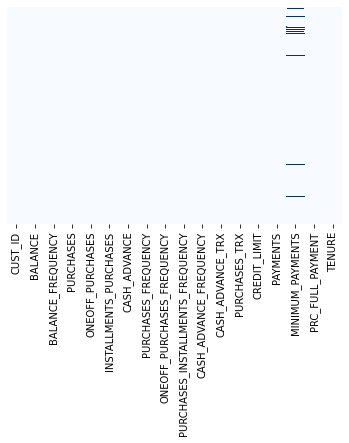

In [7]:
# Let's see if we have any missing data, luckily we don't have many!
sns.heatmap(creditcard_df.isnull(), yticklabels = False, cbar = False, cmap="Blues");

In [8]:
creditcard_df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [9]:
# Fill up the missing elements with the mean values 
creditcard_df.loc[(creditcard_df['MINIMUM_PAYMENTS'].isnull() == True), 'MINIMUM_PAYMENTS'] = creditcard_df['MINIMUM_PAYMENTS'].mean()
creditcard_df.loc[(creditcard_df['CREDIT_LIMIT'].isnull() == True), 'CREDIT_LIMIT'] = creditcard_df['CREDIT_LIMIT'].mean()

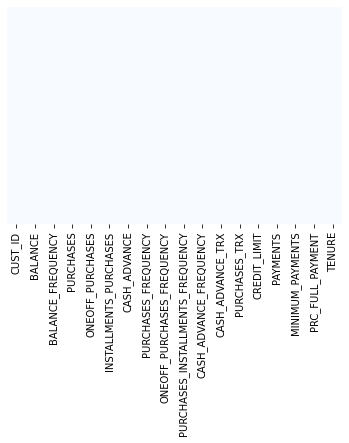

In [10]:
sns.heatmap(creditcard_df.isnull(), yticklabels = False, cbar = False, cmap="Blues");

In [11]:
# Let's see if we have duplicated entries in the data
creditcard_df.duplicated().sum()

0

In [12]:
# Let's drop Customer ID since it has no meaning here 
creditcard_df.drop("CUST_ID", axis = 1, inplace= True)
creditcard_df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [13]:
len(creditcard_df.columns)

17

In [14]:
creditcard_df.columns

Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
       'TENURE'],
      dtype='object')

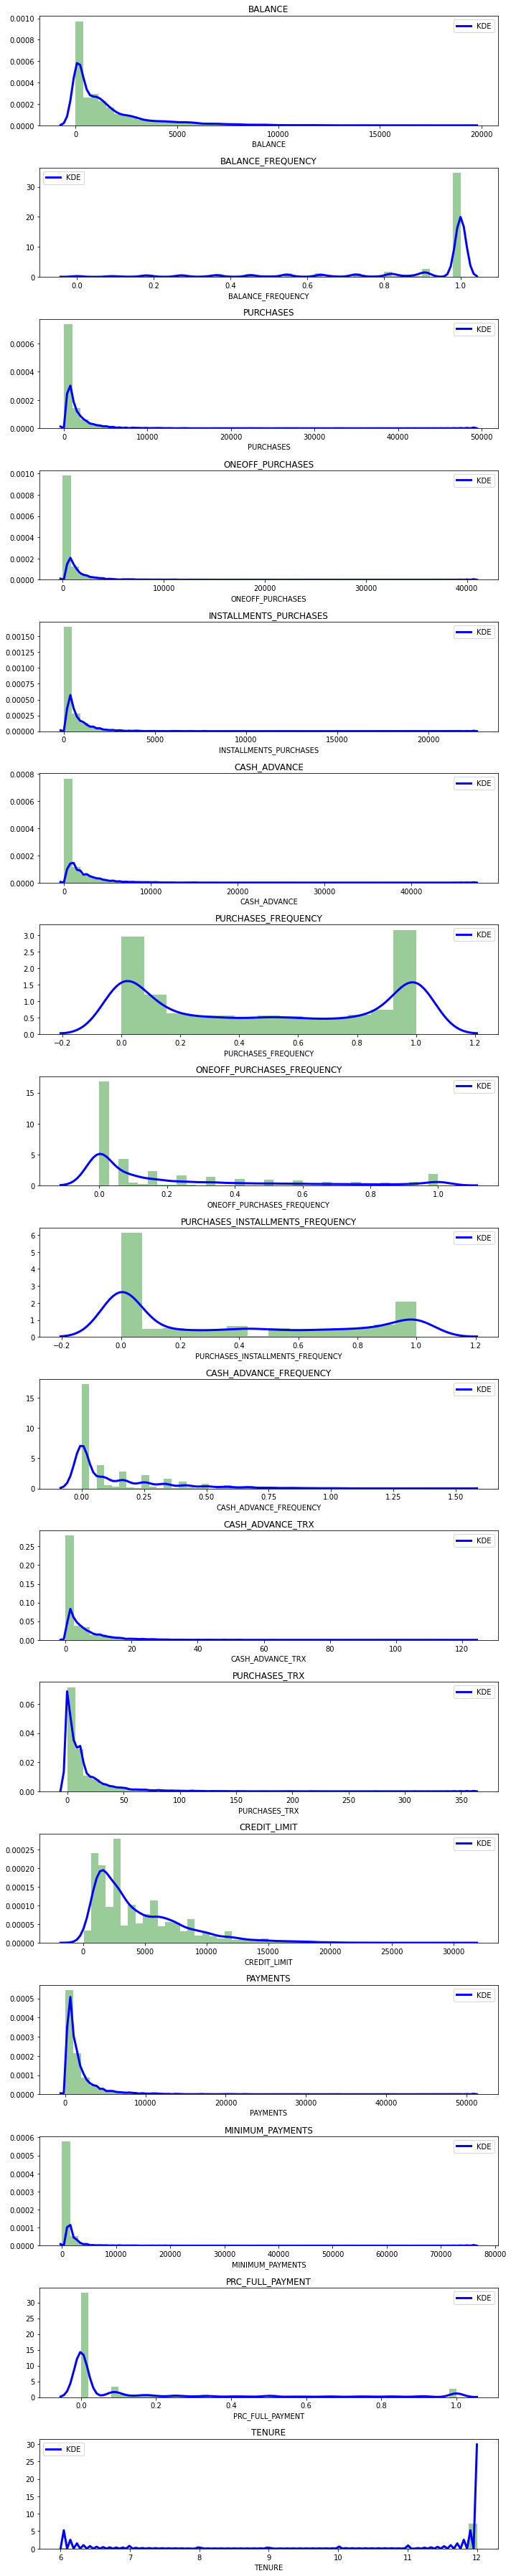

In [15]:
# distplot combines the matplotlib.hist function with seaborn kdeplot()
# KDE Plot represents the Kernel Density Estimate
# KDE is used for visualizing the Probability Density of a continuous variable. 
# KDE demonstrates the probability density at different values in a continuous variable. 

# Mean of balance is $1500
# 'Balance_Frequency' for most customers is updated frequently ~1
# For 'PURCHASES_FREQUENCY', there are two distinct group of customers
# For 'ONEOFF_PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY' most users don't do one off puchases or installment purchases frequently 
# Very small number of customers pay their balance in full 'PRC_FULL_PAYMENT'~0
# Credit limit average is around $4500
# Most customers are ~11 years tenure

plt.figure(figsize=(10,50))
for i in range(len(creditcard_df.columns)):
  plt.subplot(17, 1, i+1)
  sns.distplot(creditcard_df[creditcard_df.columns[i]], kde_kws={"color": "b", "lw": 3, "label": "KDE"}, hist_kws={"color": "g"})
  plt.title(creditcard_df.columns[i])

plt.tight_layout()

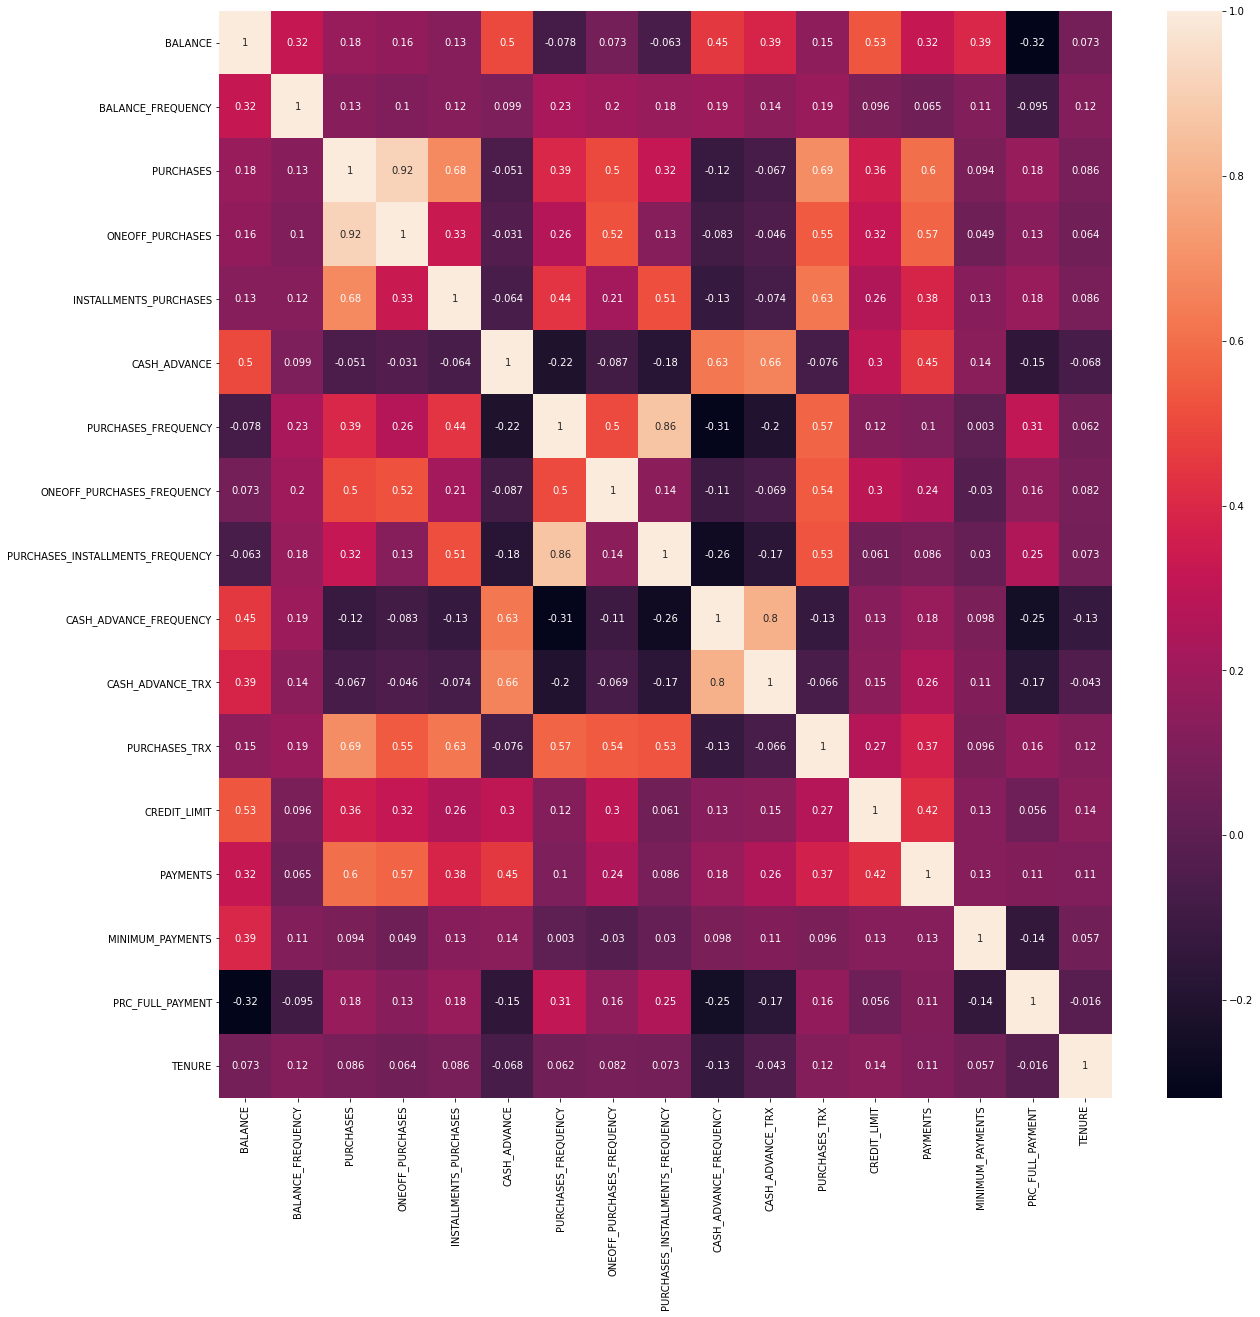

In [16]:
# obtain the correlation matrix between features
correlations = creditcard_df.corr()
f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(correlations, annot = True)

# 'PURCHASES' have high correlation between one-off purchases, 'installment purchases, purchase transactions, credit limit and payments. 
# Strong Positive Correlation between 'PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY'

### Find the Optimal Number of Clusters using Elbow Method

- The elbow method is a heuristic method of interpretation and validation of consistency within cluster analysis designed to help find the appropriate number of clusters in a dataset. 
- If the line chart looks like an arm, then the "elbow" on the arm is the value of k that is the best.
- Source: 
  - https://en.wikipedia.org/wiki/Elbow_method_(clustering)
  - https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

In [17]:
# Let's scale the data first
scaler = StandardScaler()
creditcard_df_scaled = scaler.fit_transform(creditcard_df)

In [18]:
creditcard_df_scaled.shape

(8950, 17)

In [19]:
creditcard_df_scaled

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.31096755,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.08931021,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.10166318,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.33546549,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.34690648,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.33294642,
        -0.52555097, -4.12276757]])

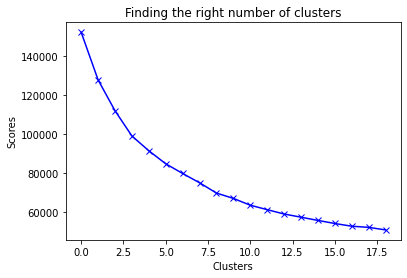

In [20]:
# Index(['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES', 'ONEOFF_PURCHASES',
#       'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PURCHASES_FREQUENCY',
#       'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY',
#       'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX',
#       'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT',
#       'TENURE'], dtype='object')

scores_1 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(creditcard_df_scaled)
  scores_1.append(kmeans.inertia_)

plt.plot(scores_1, 'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores') 
plt.show()

# From this we can observe that, 4th cluster seems to be forming the elbow of the curve. 
# However, the values does not reduce linearly until 8th cluster. 
# Let's choose the number of clusters to be 7 or 8.

### Apply K-Means Method

In [21]:
kmeans = KMeans(7)
kmeans.fit(creditcard_df_scaled)
labels = kmeans.labels_

In [22]:
kmeans.cluster_centers_.shape

(7, 17)

In [23]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [creditcard_df.columns])
cluster_centers           

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,0.014060,0.403910,-0.348145,-0.228766,-0.402668,-0.103161,-0.835380,-0.366695,-0.760428,0.088800,-0.039576,-0.473319,-0.302258,-0.249516,-0.004450,-0.455971,0.272389
1,0.574271,0.459534,1.842440,1.577256,1.458671,-0.229737,1.152101,1.783941,0.981571,-0.340514,-0.251868,2.157894,1.132376,1.003704,0.225692,0.435256,0.311447
2,1.646806,0.392921,-0.218646,-0.154790,-0.232678,1.969605,-0.460870,-0.183665,-0.416624,1.897489,1.896809,-0.261020,1.001558,0.798543,0.549181,-0.392052,0.076959
3,1.923051,0.337717,11.212042,10.600367,7.033118,0.419625,1.046983,1.915501,0.981334,-0.258912,0.061229,5.362438,3.044064,8.098975,1.120318,1.110132,0.310863
4,-0.340505,-0.328638,-0.280693,-0.207224,-0.282636,0.060768,-0.170349,-0.270729,-0.206840,0.292465,-0.007707,-0.379208,-0.560715,-0.389630,-0.208183,0.022392,-3.179625
5,-0.339932,0.353987,0.042538,-0.077367,0.242417,-0.369399,0.980989,0.222417,0.892762,-0.472836,-0.360961,0.240178,-0.134313,-0.172912,-0.085633,0.343912,0.271768
6,-0.701605,-2.138743,-0.307309,-0.232059,-0.300181,-0.323517,-0.539290,-0.439111,-0.427344,-0.522229,-0.377112,-0.415687,-0.175873,-0.201079,-0.257047,0.284231,0.198725


In [24]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [creditcard_df.columns])
cluster_centers

# First Customers cluster (Transactors): Those are customers who pay least amount of intrerest charges and careful with their money, Cluster with lowest balance ($104) and cash advance ($303), Percentage of full payment = 23%
# Second customers cluster (revolvers) who use credit card as a loan (most lucrative sector): highest balance ($5000) and cash advance (~$5000), low purchase frequency, high cash advance frequency (0.5), high cash advance transactions (16) and low percentage of full payment (3%)
# Third customer cluster (VIP/Prime): high credit limit $16K and highest percentage of full payment, target for increase credit limit and increase spending habits
# Fourth customer cluster (low tenure): these are customers with low tenure (7 years), low balance 


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,1593.739417,0.972953,259.387226,212.732824,46.940306,762.537468,0.155072,0.093066,0.062224,0.152914,2.978746,2.944885,3394.710615,1010.819016,853.835836,0.020351,11.881844
1,2759.771892,0.986130,4939.606003,3210.358741,1730.125739,497.102328,0.952745,0.734642,0.754539,0.067004,1.530015,68.346999,8614.494876,4638.769088,1390.172330,0.281019,11.934114
2,4992.162635,0.970350,536.064879,335.517572,200.659525,5109.224217,0.305381,0.147667,0.198860,0.514851,16.193157,8.221854,8138.525988,4044.848365,2144.050187,0.039046,11.620309
3,5567.142164,0.957273,24957.905000,18186.875667,6771.029333,1858.844605,0.910556,0.773889,0.754444,0.083333,3.666667,148.000000,15570.000000,25178.882690,3475.059479,0.478409,11.933333
4,855.742127,0.799419,403.500612,248.488085,155.483485,1106.304746,0.421981,0.121694,0.282234,0.193669,3.196232,5.284144,2454.339795,605.204525,379.043805,0.160264,7.262166
5,856.934057,0.961127,1094.088355,464.024179,630.282497,204.225081,0.884069,0.268809,0.719244,0.040525,0.785531,20.679765,4005.764772,1232.580743,664.642734,0.254303,11.881014
6,104.144016,0.370622,346.635155,207.266268,139.617255,300.441889,0.273907,0.071462,0.194600,0.030641,0.675314,4.377406,3854.551836,1151.040046,265.170083,0.236847,11.783264


In [25]:
labels.shape # Labels associated to each data point

(8950,)

In [26]:
labels.max()

6

In [27]:
labels.min()

0

In [28]:
y_kmeans = kmeans.fit_predict(creditcard_df_scaled)
y_kmeans


array([0, 3, 2, ..., 1, 0, 0], dtype=int32)

In [29]:
# concatenate the clusters labels to our original dataframe
creditcard_df_cluster = pd.concat([creditcard_df, pd.DataFrame({'cluster':labels})], axis = 1)
creditcard_df_cluster.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,cluster
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,2
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,5
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12,0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


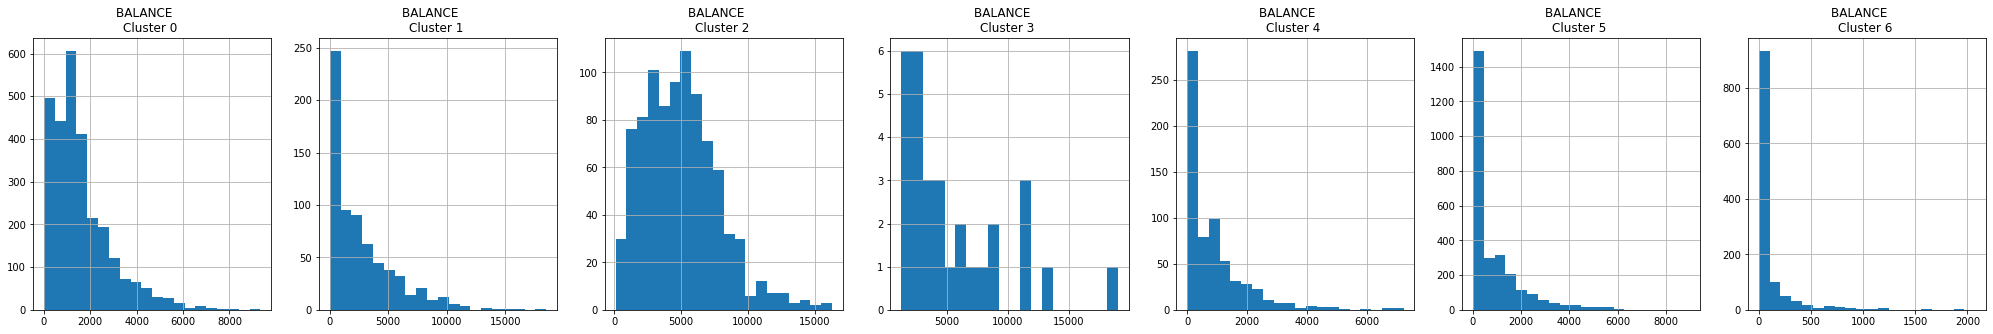

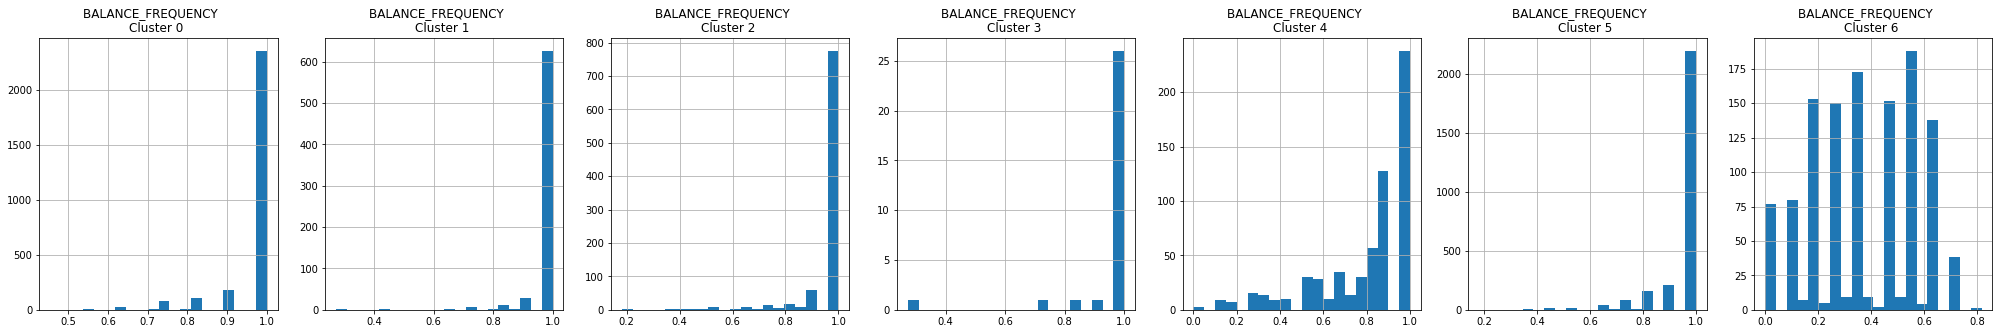

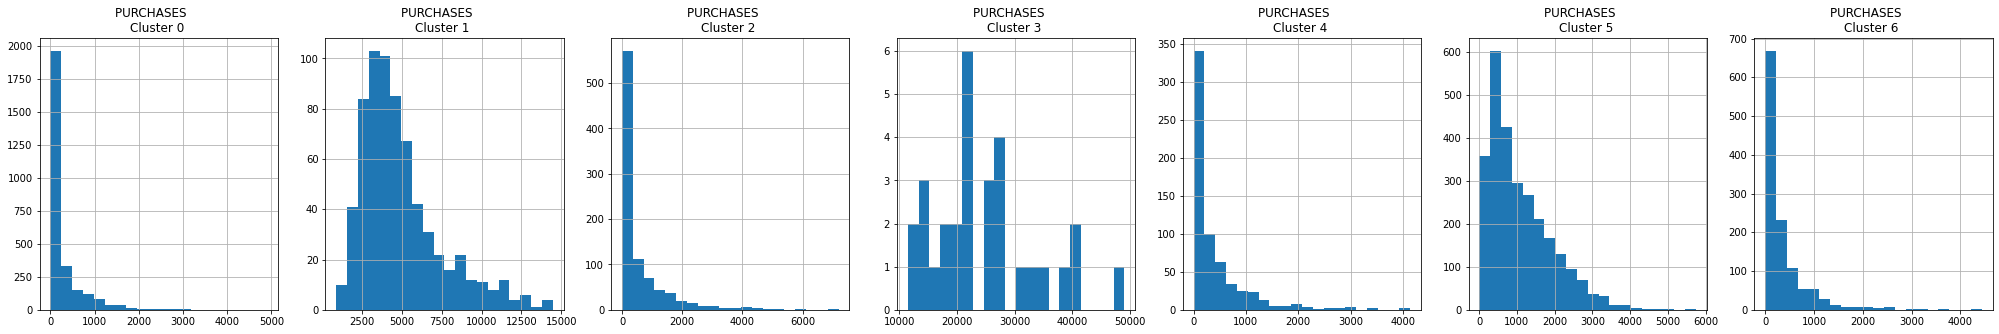

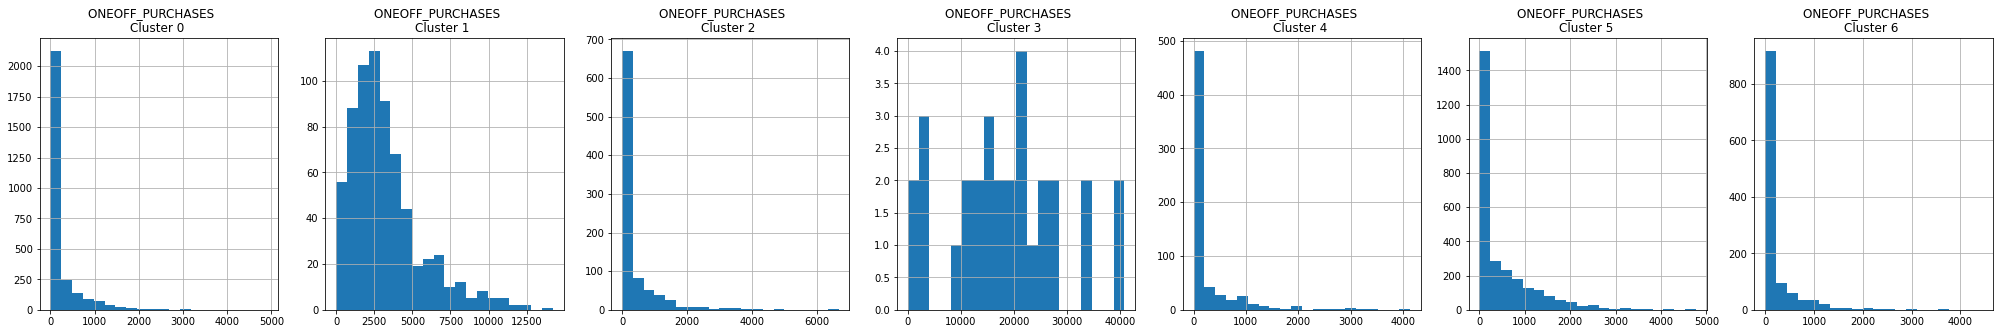

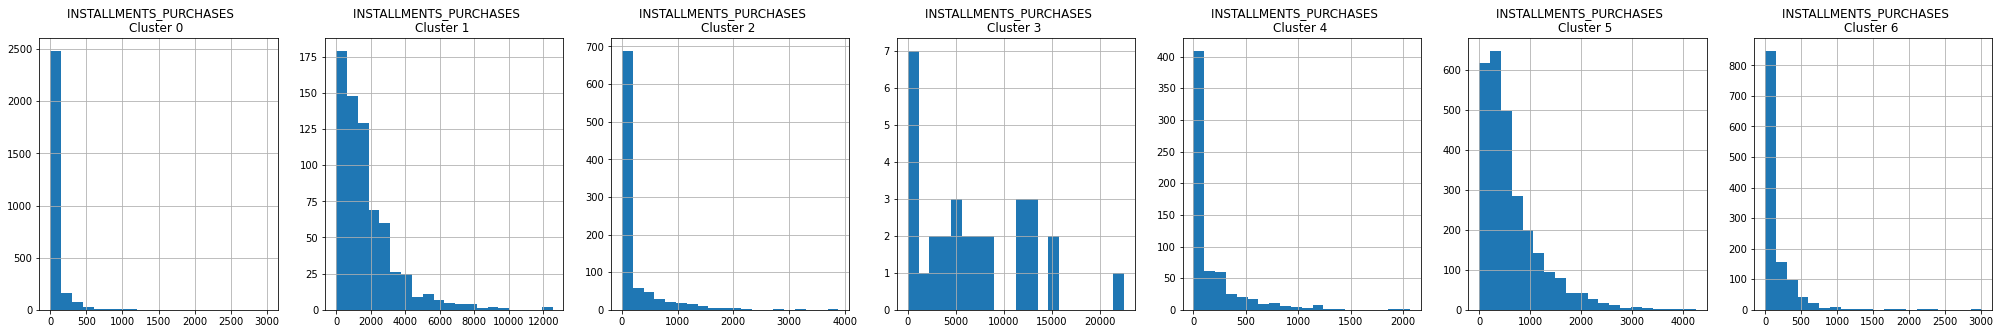

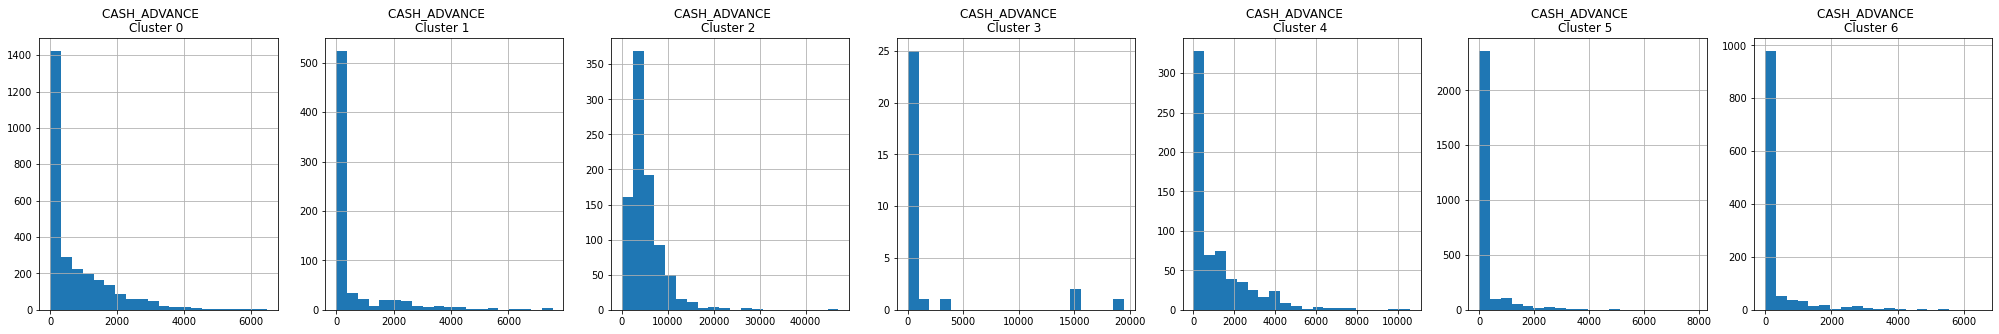

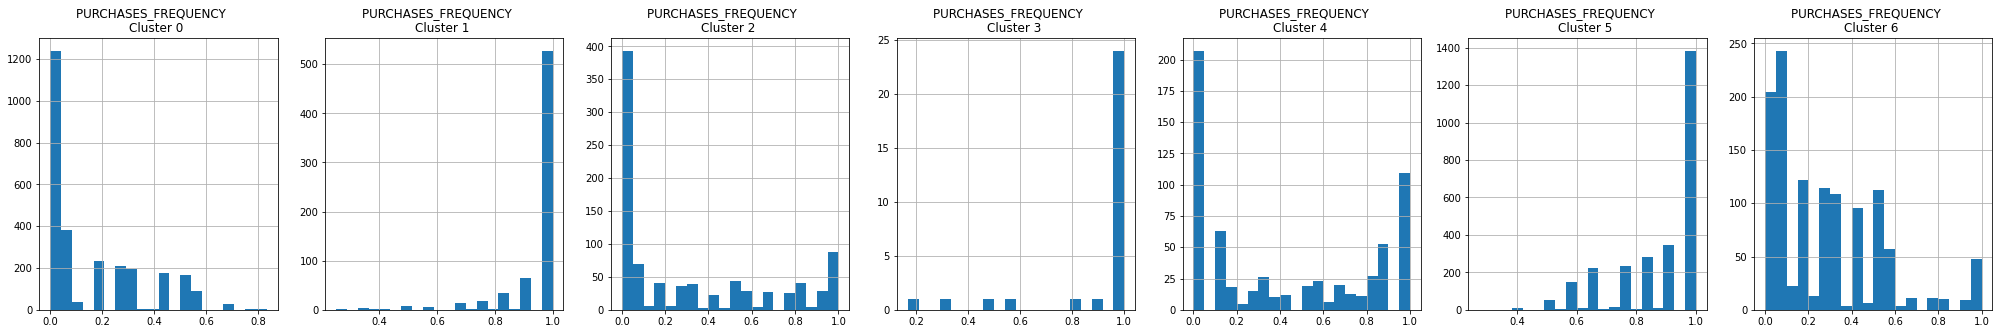

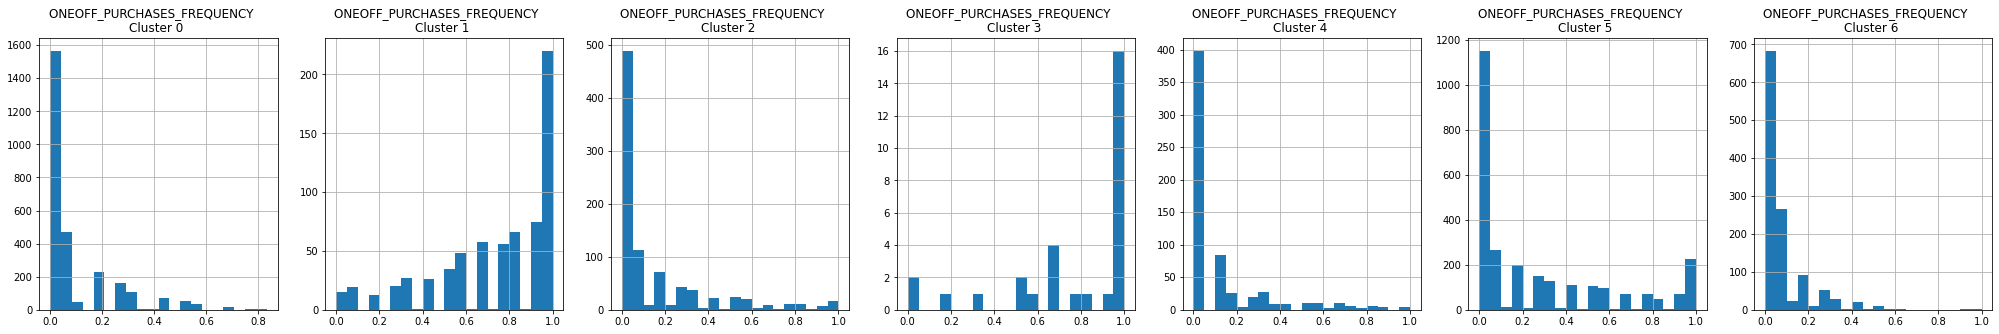

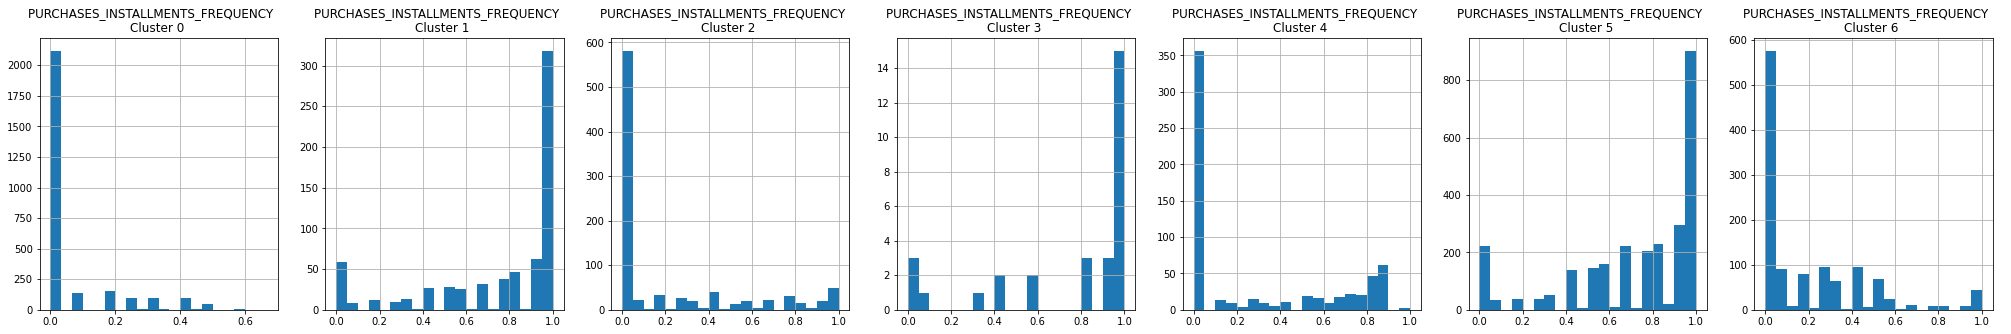

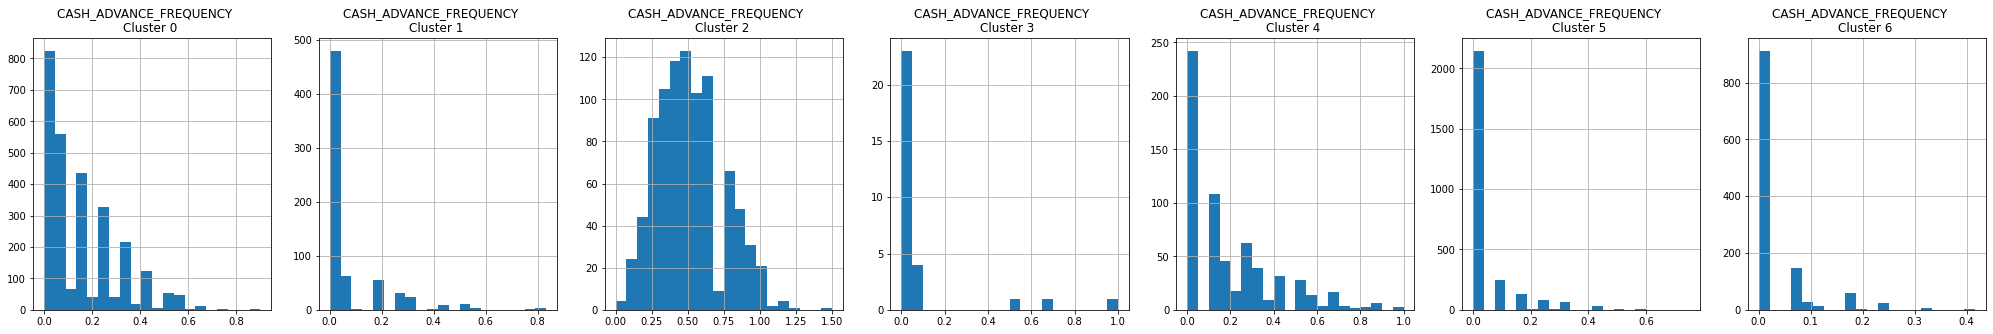

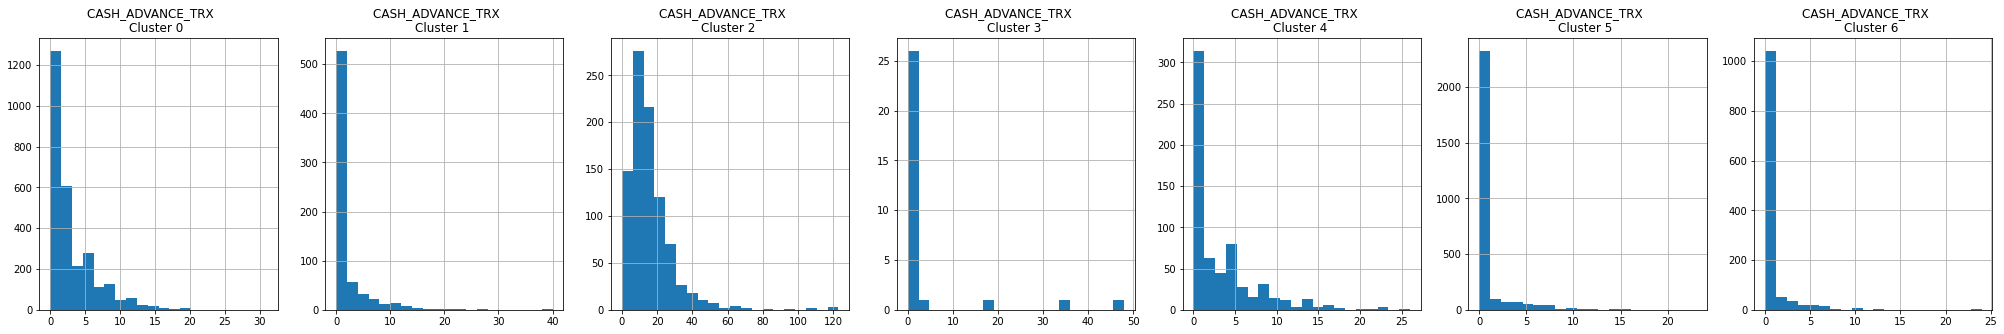

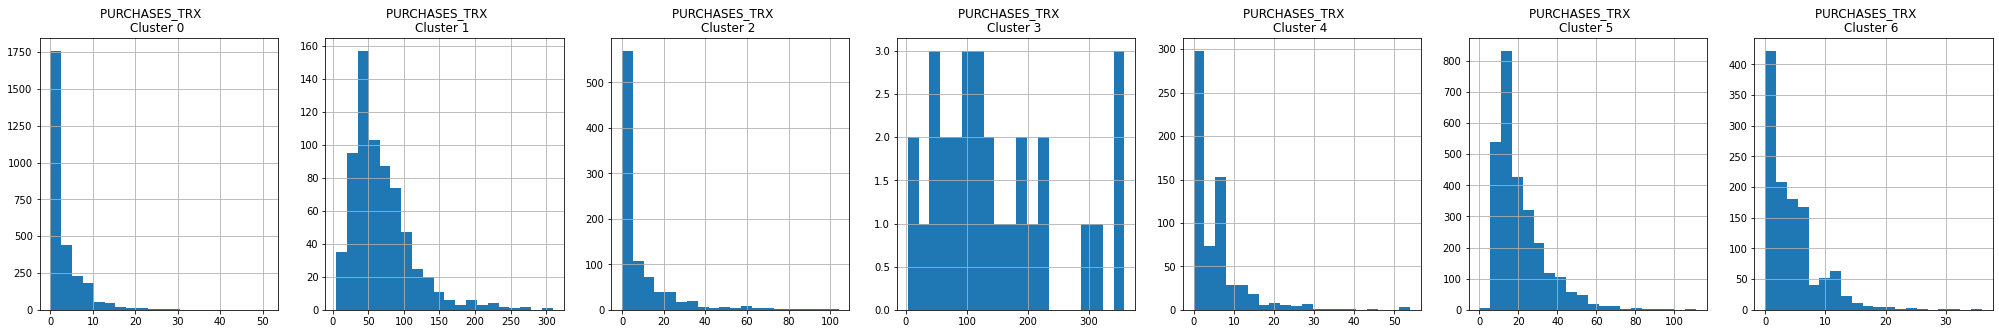

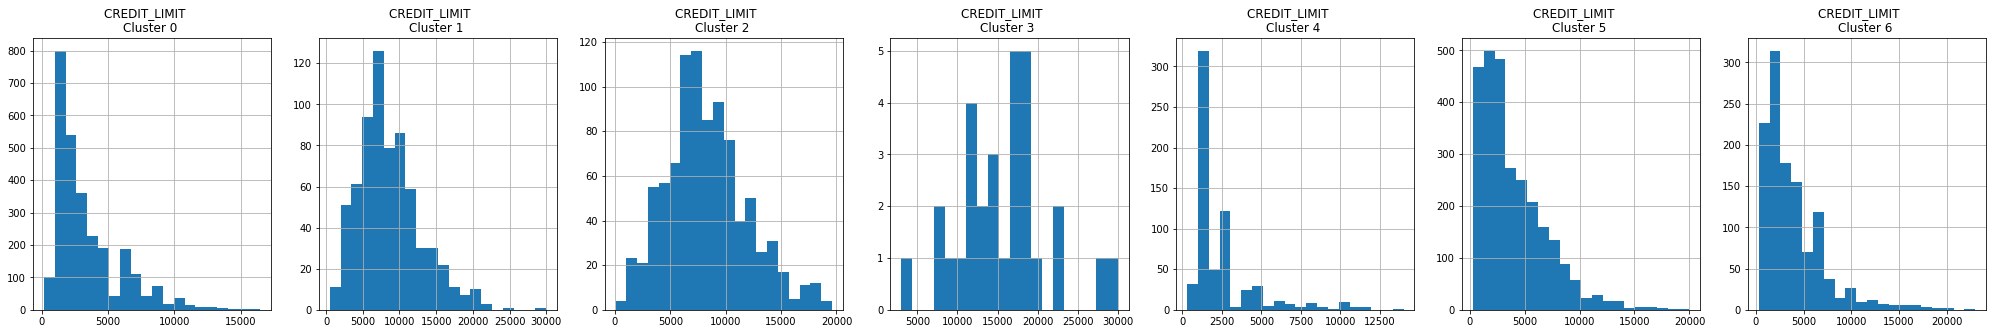

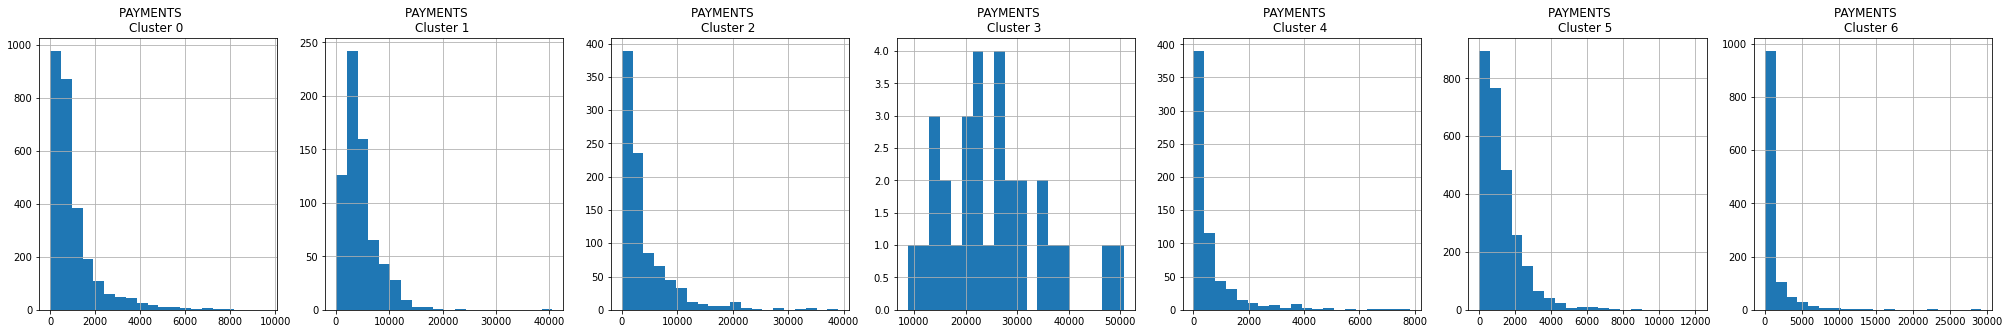

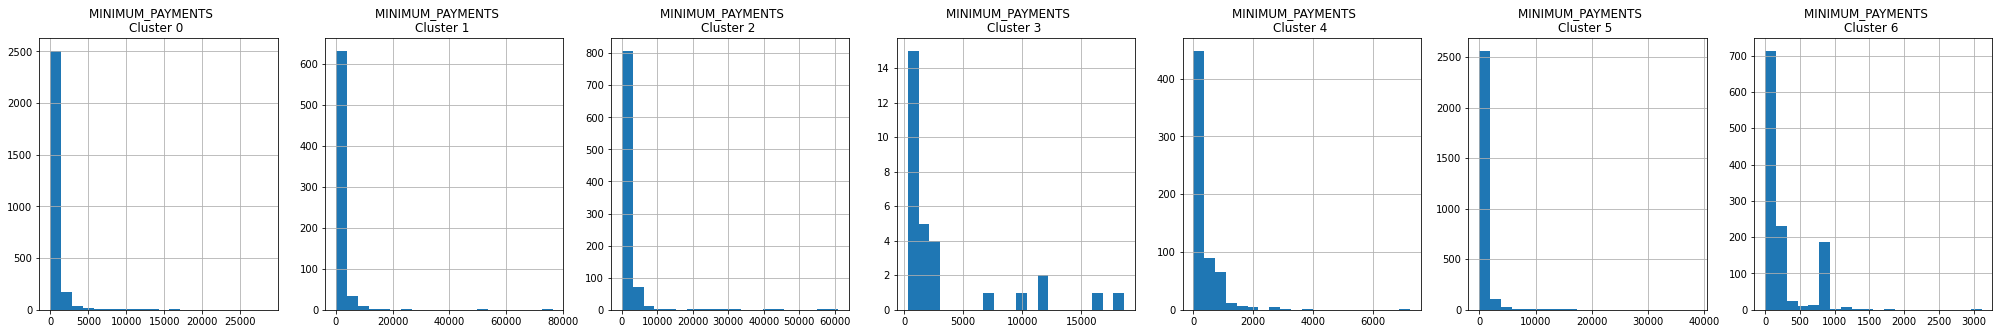

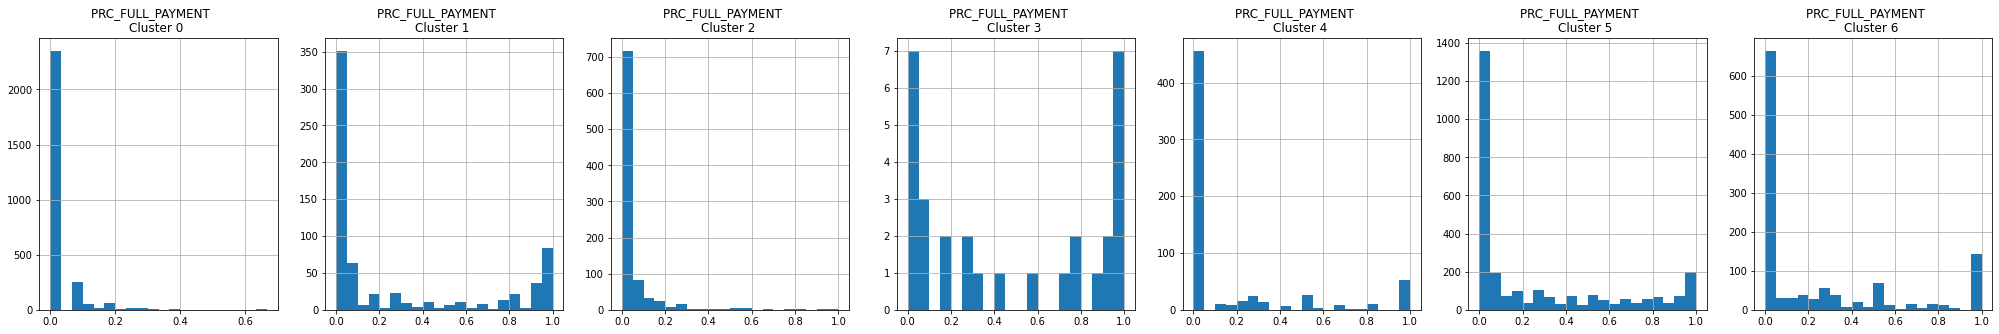

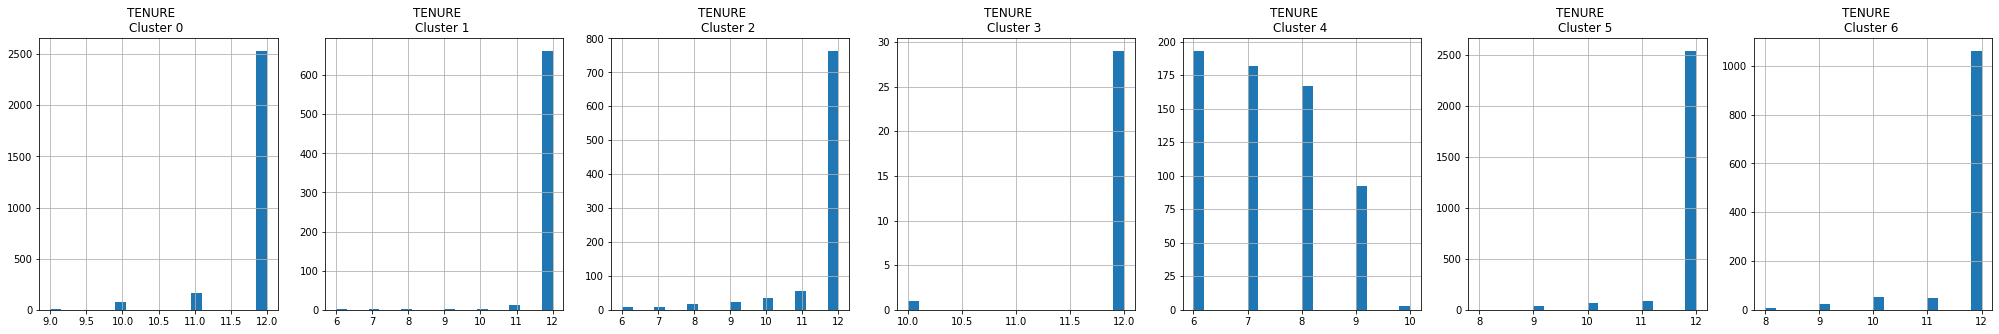

In [30]:
# Plot the histogram of various clusters
for i in creditcard_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(7):
    plt.subplot(1,7,j+1)
    cluster = creditcard_df_cluster[creditcard_df_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()


### Apply Principal Component Analysis and Visualize the Results

In [31]:
# Obtain the principal components 
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(creditcard_df_scaled)
principal_comp

array([[-1.6822203 , -1.07645161],
       [-1.13829855,  2.50647101],
       [ 0.9696861 , -0.38351967],
       ...,
       [-0.92620305, -1.81078521],
       [-2.33655069, -0.65796398],
       [-0.5564219 , -0.40046448]])

In [32]:
# Create a dataframe with the two components
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-1.682220,-1.076452
1,-1.138299,2.506471
2,0.969686,-0.383520
3,-0.873627,0.043165
4,-1.599434,-0.688581


In [33]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,cluster
0,-1.682220,-1.076452,0
1,-1.138299,2.506471,2
2,0.969686,-0.383520,5
3,-0.873627,0.043165,0
4,-1.599434,-0.688581,0


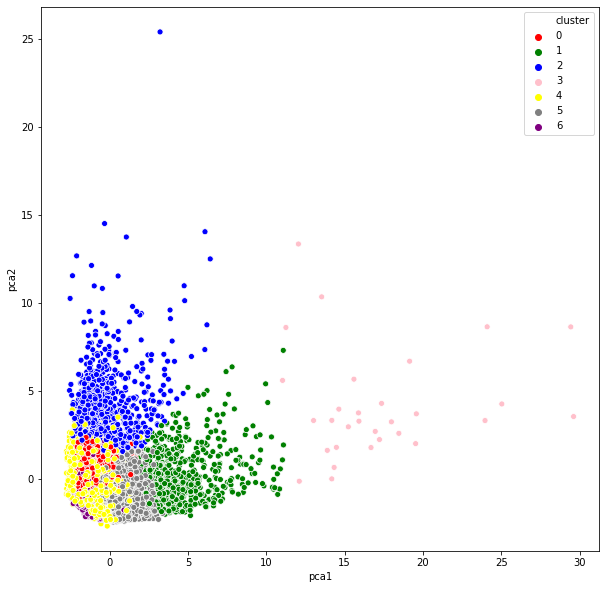

In [34]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','pink','yellow','gray','purple'])
plt.show()